# Evaluation and Metrics

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import PrecisionRecallDisplay
from requests import get

In [2]:
URL = 'http://localhost:8983/solr/movies/select'

In [3]:
# METRICS TABLE
# Define custom decorator to automatically calculate metric based on key
metrics = {}
metric = lambda f: metrics.setdefault(f.__name__, f)

@metric
def ap(results, relevant):
    """Average Precision"""
    relevant_index = []
    index = 0
    for res in results:
        if (index != 0 and res['imdb_title_id'] in relevant) or (index == 0 and res['imdb_title_id'][0] in relevant):
            relevant_index.append(index)
        index = index + 1

    if len(relevant_index) == 0:
        return 0

    precision_values = [
        len([
            doc
            for doc in results[:idx]
            if (index != 0 and doc['imdb_title_id'] in relevant) or (index == 0 and doc['imdb_title_id'][0] in relevant)
        ]) / idx
        for idx in range(1, len(results) + 1)
    ]

    precision_sum = 0
    for ind in relevant_index:
        precision_sum = precision_sum + precision_values[ind]

    return precision_sum / len(relevant_index)

@metric
def p10(results, relevant, n=10):
    """Precision at N"""
    return len([doc for doc in results[:n] if doc['imdb_title_id'] in relevant])/n

def calculate_metric(key, results, relevant):
    return metrics[key](results, relevant)

# Define metrics to be calculated
evaluation_metrics = {
    'ap': 'Average Precision',
    'p10': 'Precision at 10 (P@10)'
}

def metrics_export_table(results: list, relevant: list):
    df = pd.DataFrame([['Metric','Value']] +
        [
            [evaluation_metrics[m], calculate_metric(m, results, relevant)]
            for m in evaluation_metrics
        ]
    )

    return df

In [4]:
# PRECISION-RECALL CURVE
# Calculate precision and recall values as we move down the ranked list
def curve(results: list, relevant: list):
    precision_values = [
        len([
            doc 
            for doc in results[:idx]
            if doc['imdb_title_id'] in relevant
        ]) / idx 
        for idx, _ in enumerate(results, start=1)
    ]

    recall_values = [
        len([
            doc for doc in results[:idx]
            if doc['imdb_title_id'] in relevant
        ]) / len(relevant)
        for idx, _ in enumerate(results, start=1)
    ]

    precision_recall_match = {k: v for k,v in zip(recall_values, precision_values)}

    # Extend recall_values to include traditional steps for a better curve (0.1, 0.2 ...)
    recall_values.extend([step for step in np.arange(0, 1.1, 0.3) if step not in recall_values])
    recall_values = sorted(set(recall_values))

    # Extend matching dict to include these new intermediate steps
    for idx, step in enumerate(recall_values):
        if idx > 0 and step not in precision_recall_match:
            if recall_values[idx-1] in precision_recall_match:
                precision_recall_match[step] = precision_recall_match[recall_values[idx-1]]
            else:
                precision_recall_match[step] = precision_recall_match[recall_values[idx+1]]

    return PrecisionRecallDisplay([precision_recall_match.get(r) for r in recall_values], recall_values)

In [5]:
def get_results(params: dict):
    return get(URL, params=params).json()['response']['docs']

In [6]:
def print_titles(dataset: list):
    for title in dataset:
        print('%s: %d %s' % (title['imdb_title_id'], title['year'], title['original_title']))

## Experiment 1 - Matrix Trilogy

In [7]:
# schema-less
relevant = list(map(lambda el: el.strip(), open('matrix_qrels.txt').readlines()))

standard_params = {
    'q': 'title:matrix original_title:matrix description:(matrix neo) plot:(matrix neo) ',
    'wt': 'json',
    'defType': 'edismax'
}

schemaless_results = get_results(params=standard_params)

In [8]:
standard_results = get_results(params=standard_params)

enhanced_params = {
    'q': '(original_title:matrix title:matrix) AND (description:neo plot:neo)',
    'wt': 'json',
    'qf': 'original_title description^2 plot^3',
    'defType': 'edismax'
}

enhanced_results = get_results(params=enhanced_params)

In [9]:
print_titles(standard_results)

tt0234215: 2003 The Matrix Reloaded
tt0242653: 2003 The Matrix Revolutions
tt0133093: 1999 The Matrix
tt0970173: 2007 Buhera mátrix
tt0415955: 2004 Maarek hob
tt0292097: 2000 Markova: Comfort Gay
tt0102421: 1991 Mayrig
tt0074883: 1976 Maîtresse
tt0437526: 2007 Une vieille maîtresse
tt0084315: 1982 Les maîtres du temps


In [10]:
print_titles(enhanced_results)

tt0234215: 2003 The Matrix Reloaded
tt0242653: 2003 The Matrix Revolutions
tt0133093: 1999 The Matrix


In [11]:
schemaless_table = metrics_export_table(results=schemaless_results, relevant=relevant)
standard_table = metrics_export_table(results=standard_results, relevant=relevant)
enhanced_table = metrics_export_table(results=enhanced_results, relevant=relevant)

schemaless_curve = curve(results=schemaless_results, relevant=relevant)
standard_curve = curve(results=standard_results, relevant=relevant)
enhanced_curve = curve(results=enhanced_results, relevant=relevant)

In [12]:
print(schemaless_table)
print(standard_table)
print(enhanced_table)

                        0      1
0                  Metric  Value
1       Average Precision    0.0
2  Precision at 10 (P@10)    0.0
                        0      1
0                  Metric  Value
1       Average Precision    1.0
2  Precision at 10 (P@10)    0.3
                        0      1
0                  Metric  Value
1       Average Precision    1.0
2  Precision at 10 (P@10)    0.3


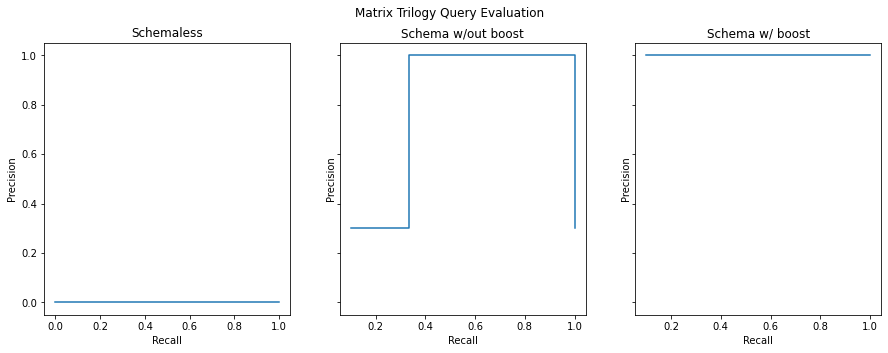

In [30]:
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, sharey=True, figsize=(15,5))

ax1.set_title('Schemaless')
ax2.set_title('Schema w/out boost')
ax3.set_title('Schema w/ boost')
fig.suptitle('Matrix Trilogy Query Evaluation')

schemaless_curve.plot(ax=ax1)
standard_curve.plot(ax=ax2)
enhanced_curve.plot(ax=ax3)

plt.show()

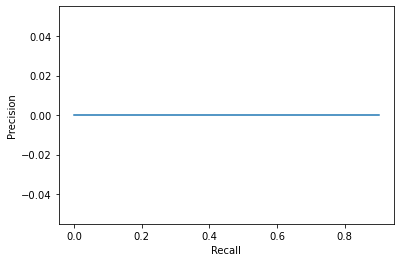

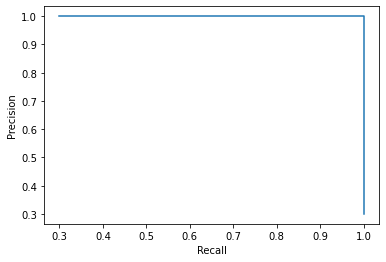

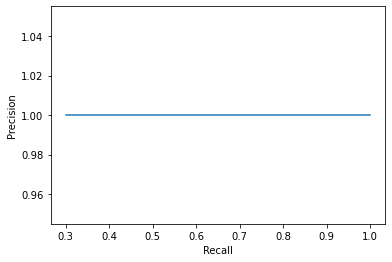

In [16]:
schemaless_curve.plot()
plt.savefig('plots/exp1_1.png')
standard_curve.plot()
plt.savefig('plots/exp1_2.png')
enhanced_curve.plot()
plt.savefig('plots/exp1_3.png')